<a href="https://colab.research.google.com/github/yunakam/music_genre_classification/blob/main/Music_Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# プロダクト開発課題
* テーマ設定：楽曲のジャンル分類
* データセット：GTZAN (https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification)
* 特徴量：MFCC
* モデル構築
  * LSTMモデル・・・楽曲のシーケンス特性に注目
  * CNNモデル・・・楽曲の周波数特性に注目
  * CNNモデル（1D畳み込み）・・・楽曲の局所的な特徴に注目

<br>
※参考文献<br>
Luo, X. (2023). Automatic Music Genre Classification based on CNN and LSTM. Highlights in Science, Engineering and Technology. 39. 61-66. 10.54097/hset.v39i.6494.<br>
Premtibadiya (2020). Music Genre Classification using RNN-LSTM. https://medium.com/@premtibadiya/music-genre-classification-using-rnn-lstm-1c212ba21e06<br>
Rajat, K. (n.d.). Music Genre Classification Using LSTM. https://www.servomagazine.com/magazine/article/music-genre-classification-using-lstm<br>






In [ ]:
import math
import json
import os
import pickle
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa  # https://librosa.org/doc/latest/index.html
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Specify the path to the Kaggle API key
path = "/content/drive/My Drive/Colab Notebooks"
os.environ['KAGGLE_CONFIG_DIR'] = os.path.dirname(path)

# Copy kaggle.json to the home directory and set access permissions
!mkdir -p ~/.kaggle
!cp "/content/drive/My Drive/Colab Notebooks/kaggle.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

## データ準備

In [ ]:
# Download GTZAN dataset
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification -p "/content/drive/My Drive/Colab Notebooks/Music-Genre-Classification"
!unzip "/content/drive/My Drive/Colab Notebooks/Music-Genre-Classification/gtzan-dataset-music-genre-classification.zip" -d "/content/drive/My Drive/Colab Notebooks/Music-Genre-Classification"

Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
100% 1.21G/1.21G [00:16<00:00, 50.7MB/s]
100% 1.21G/1.21G [00:16<00:00, 77.9MB/s]
Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_or

In [ ]:
base_path = '/content/drive/My Drive/Colab Notebooks/Music-Genre-Classification'
data_path = os.path.join(base_path, 'Data', 'genres_original')

In [ ]:
# Retrieve the saved 'data' object
# objects_to_save = [data, history_LSTM_0, history_LSTM_2a, history_Conv1D_0, history_Conv1D_2a]

with open(os.path.join(base_path, 'saved_state.pkl'), 'rb') as f:
    loaded_objects = pickle.load(f)

data = loaded_objects["data"]
# history_LSTM_0 = loaded_objects["history_LSTM_0"]
# history_LSTM_1a = loaded_objects["history_LSTM_1a"]
# history_LSTM_2a = loaded_objects["history_LSTM_2a"]
# history_Conv1D_0 = loaded_objects["history_Conv1D_0"]
# history_Conv1D_2a = loaded_objects["history_Conv1D_2a"]

In [ ]:
objects_to_save = {}

In [ ]:
print("Contents of current directory:", os.listdir(data_path))

Contents of current directory: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [ ]:
for dirpath, dirnames, filenames in os.walk(data_path):
    print(f"Found directory: {dirpath}")
    for filename in filenames[:1]:
        print(filename)

Found directory: /content/drive/My Drive/Colab Notebooks/Music-Genre-Classification/Data/genres_original
Found directory: /content/drive/My Drive/Colab Notebooks/Music-Genre-Classification/Data/genres_original/blues
blues.00001.wav
blues.00005.wav
blues.00007.wav
Found directory: /content/drive/My Drive/Colab Notebooks/Music-Genre-Classification/Data/genres_original/classical
classical.00002.wav
classical.00005.wav
classical.00003.wav
Found directory: /content/drive/My Drive/Colab Notebooks/Music-Genre-Classification/Data/genres_original/country
country.00001.wav
country.00000.wav
country.00003.wav
Found directory: /content/drive/My Drive/Colab Notebooks/Music-Genre-Classification/Data/genres_original/disco
disco.00002.wav
disco.00001.wav
disco.00003.wav
Found directory: /content/drive/My Drive/Colab Notebooks/Music-Genre-Classification/Data/genres_original/hiphop
hiphop.00001.wav
hiphop.00007.wav
hiphop.00010.wav
Found directory: /content/drive/My Drive/Colab Notebooks/Music-Genre-Cla

In [ ]:
# # Function to get MFCC
# def get_mfcc(data_path, n_mfcc=40, n_fft=2048, hop_length=512, num_songs_genre=10):
#     data = {"labels": [], "mfcc": []}
#     sample_rate = 22050
#     samples_per_segment = int(sample_rate * 30 / num_songs_genre)

#     for label_idx, (dirpath, dirnames, filenames) in enumerate(os.walk(data_path)):
#         if dirpath == data_path:  # Skip the top-level directory
#             continue

#         label = os.path.basename(dirpath)  # Obtain the genre name from the directory name
#         print(f"Processing genre: {label}")

#         for f in sorted(filenames):
#             if not f.endswith('.wav'):  # Only process .wav files
#                 continue

#             file_path = os.path.join(dirpath, f)

#             try:
#                 y, sr = librosa.load(file_path, sr=sample_rate)
#             except Exception as e:
#                 print(f"Error loading {file_path}: {e}")
#                 continue

#             for n in range(num_songs_genre):
#                 start_sample = samples_per_segment * n
#                 end_sample = start_sample + samples_per_segment
#                 if end_sample > len(y):
#                     continue

#                 mfcc = librosa.feature.mfcc(y=y[start_sample:end_sample], sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
#                 mfcc = mfcc.T  # Rearrange the data so that the time series is in rows

#                 if len(mfcc) == math.ceil(samples_per_segment / hop_length):
#                     data["labels"].append(label)
#                     data["mfcc"].append(mfcc.tolist())

#     return data


In [ ]:
# Modified function to get MFCC (excludes directories where augmented dataset are stored)
def get_mfcc(data_path, n_mfcc=40, n_fft=2048, hop_length=512, num_songs_genre=10):
    data = {"labels": [], "mfcc": []}
    sample_rate = 22050
    samples_per_segment = int(sample_rate * 30 / num_songs_genre)
    exclude_dirs = {'augmented_pitch_speed', 'augmented_noise'}  # Set of directories to exclude

    for label_idx, (dirpath, dirnames, filenames) in enumerate(os.walk(data_path)):

        if os.path.basename(dirpath) in exclude_dirs:  # Skip the directories in the exclude list
            continue

        if dirpath == data_path:  # Skip the top-level directory
            continue

        label = os.path.basename(dirpath)  # Obtain the genre name from the directory name
        print(f"Processing genre: {label}")

        for f in sorted(filenames):
            if not f.endswith('.wav'):  # Only process .wav files
                continue

            file_path = os.path.join(dirpath, f)

            try:
                y, sr = librosa.load(file_path, sr=sample_rate)
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
                continue

            for n in range(num_songs_genre):
                start_sample = samples_per_segment * n
                end_sample = start_sample + samples_per_segment
                if end_sample > len(y):
                    continue

                mfcc = librosa.feature.mfcc(y=y[start_sample:end_sample], sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
                mfcc = mfcc.T  # Rearrange the data so that the time series is in rows

                if len(mfcc) == math.ceil(samples_per_segment / hop_length):
                    data["labels"].append(label)
                    data["mfcc"].append(mfcc.tolist())

    return data


In [ ]:
# Extract mfcc_data from the songs list
data = get_mfcc(data_path, n_mfcc=13, n_fft=2048, hop_length=512, num_songs_genre=10)

Processing genre: blues
Processing genre: classical
Processing genre: country
Processing genre: disco
Processing genre: hiphop
Processing genre: jazz
Processing genre: metal
Processing genre: pop
Processing genre: reggae
Processing genre: rock


In [ ]:
objects_to_save["data"] = data

## LSTMモデル

In [ ]:
# Encode labels into integer (otherwise causes ValueError: Invalid dtype)
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(data["labels"])

# Training & testing dataset
x = np.array(data["mfcc"])
y = np.array(data["labels"])

x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.25)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

input_shape = (x_train.shape[1], x_train.shape[2])  # time steps, number of MFCC features

In [ ]:
print(input_shape)

(130, 13)


#### Basic LSTM

In [ ]:
# Basic model construction using LSTM
model_LSTM_0 = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model_LSTM_0.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_LSTM_0.summary()
history_LSTM_0 = model_LSTM_0.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=20, verbose=2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 130, 64)             │          19,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,802 (225.79 KB)

 Trainable params: 57,802 (225.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
188/188 - 37s - 196ms/step - accuracy: 0.3829 - loss: 1.6935 - val_accuracy: 0.4770 - val_loss: 1.4430
Epoch 2/20
188/188 - 34s - 178ms/step - accuracy: 0.4811 - loss: 1.4329 - val_accuracy: 0.5230 - val_loss: 1.3347
Epoch 3/20
188/188 - 41s - 221ms/step - accuracy: 0.5286 - loss: 1.2907 - val_accuracy: 0.5224 - val_loss: 1.2811
Epoch 4/20
188/188 - 43s - 230ms/step - accuracy: 0.5588 - loss: 1.1848 - val_accuracy: 0.5752 - val_loss: 1.1841
Epoch 5/20
188/188 - 38s - 202ms/step - accuracy: 0.6080 - loss: 1.0843 - val_accuracy: 0.5812 - val_loss: 1.1774
Epoch 6/20
188/188 - 23s - 124ms/step - accuracy: 0.6440 - loss: 0.9869 - val_accuracy: 0.6112 - val_loss: 1.0737
Epoch 7/20
188/188 - 41s - 219ms/step - accuracy: 0.6779 - loss: 0.8938 - val_accuracy: 0.6513 - val_loss: 0.9835
Epoch 8/20
188/188 - 40s - 212ms/step - accuracy: 0.7109 - loss: 0.8157 - val_accuracy: 0.6560 - val_loss: 1.0164
Epoch 9/20
188/188 - 40s - 213ms/step - accuracy: 0.7201 - loss: 0.7844 - val_accuracy: 

NameError: name 'objects_to_save' is not defined

In [ ]:
objects_to_save["history_LSTM_0"] = history_LSTM_0

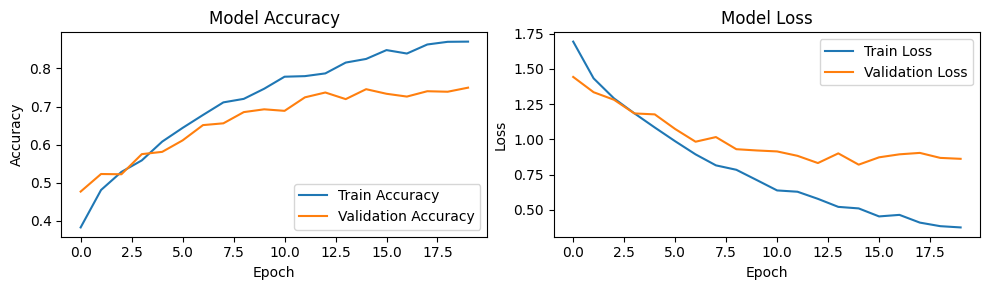

In [ ]:
# Plot acurracy & loss of training and testing

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# accuracy
ax1.plot(history_LSTM_0.history['accuracy'], label='Train Accuracy')
ax1.plot(history_LSTM_0.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='lower right')

# loss
ax2.plot(history_LSTM_0.history['loss'], label='Train Loss')
ax2.plot(history_LSTM_0.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper right')

# show layout
plt.tight_layout()
plt.show()

訓練精度は頭打ちをしていないようなのでエポック数を増やせば更に上がることも予想されるが、エポック数が4を超えるあたりから過学習の傾向が高まっている。
また検証損失が12エポックを超えたあたりから減らせていないのでエポック回数を増やすことが有効か怪しい。

#### LSTMモデル改善案
##### 1. ハイパーパラメータ
  1. a) LSTMユニット数の増加<br>
        →ユニットを増やすことでより複雑な特徴を捉えられる可能性
  2. b) Adamの学習率を下げる（今回は採用しない）

##### 2. 層の追加
  1. a) LSTM層の前に1次元畳み込み/バッチ正規化/Max Poolingを追加
        →LSTMが処理する前に曲の局所的データを抽出
  2. b) LSTM, Dense層の後にバッチ正規化を追加

##### 3. 正則化
  1. a) ドロップアウト層追加
  2. b) ノルム正則化<br>
    →過学習抑制

##### 4. データ拡張
  1. a) ピッチや再生速度の変更
  2. b) ノイズの追加


##### 128-Unit LSTM Model

In [ ]:
# Model improvement: 1a. Increase LSTM units

model_LSTM_1a = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=input_shape, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model_LSTM_1a.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_LSTM_1a.summary()
history_LSTM_1a = model_LSTM_1a.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=20)
objects_to_save["history_LSTM_1a"] = history_LSTM_1a

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 130, 128)            │          72,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 213,194 (832.79 KB)

 Trainable params: 213,194 (832.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 77s 393ms/step - accuracy: 0.3514 - loss: 1.8072 - val_accuracy: 0.5077 - val_loss: 1.3485
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 81s 387ms/step - accuracy: 0.5187 - loss: 1.3108 - val_accuracy: 0.5625 - val_loss: 1.2416
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 385ms/step - accuracy: 0.5666 - loss: 1.1856 - val_accuracy: 0.5611 - val_loss: 1.2287
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 73s 389ms/step - accuracy: 0.5993 - loss: 1.1180 - val_accuracy: 0.5992 - val_loss: 1.1294
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 390ms/step - accuracy: 0.6110 - loss: 1.0665 - val_accuracy: 0.6059 - val_loss: 1.1040
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 73s 391ms/step - accuracy: 0.6678 - loss: 0.9278 - val_accuracy: 0.5625 - val_loss: 1.3464
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 388ms/step - accuracy: 0.6361 - loss: 1.0557 - val_accuracy: 0.6573 - val_loss: 0.9595
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 83s 398ms/step - accuracy: 0.6991 - loss: 0

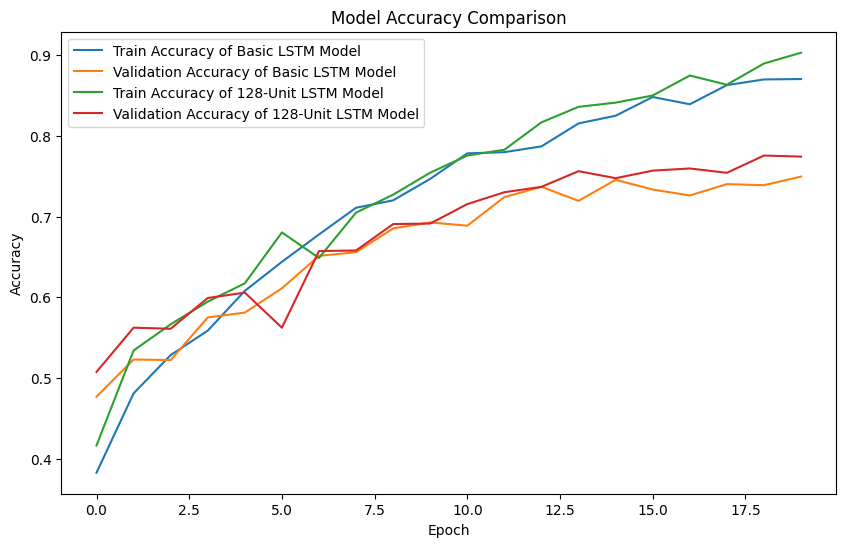

In [ ]:
# Compare Basic model (0) and 128-unit model (1a)
plt.figure(figsize=(10, 6))
plt.plot(history_LSTM_0.history['accuracy'], label='Train Accuracy of Basic LSTM Model')
plt.plot(history_LSTM_0.history['val_accuracy'], label='Validation Accuracy of Basic LSTM Model')
plt.plot(history_LSTM_1a.history['accuracy'], label='Train Accuracy of 128-Unit LSTM Model')
plt.plot(history_LSTM_1a.history['val_accuracy'], label='Validation Accuracy of 128-Unit LSTM Model')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Increasing LSTM units improved both training & validation accuracy, but took very long to process.
--> Can replacing LSTM with GRU decrease the computational cost?

##### 128-Unit GRU Model

In [ ]:
# Experiment: Use GRU instead of LSTM

model_GRU_1a = tf.keras.Sequential([
    tf.keras.layers.GRU(128, input_shape=input_shape, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model_GRU_1a.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_GRU_1a.summary()
# try with 3 epoch to see how long it takes to compute
history_GRU_1a = model_GRU_1a.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=3)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 130, 128)            │          54,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 162,890 (636.29 KB)

 Trainable params: 162,890 (636.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 322ms/step - accuracy: 0.3786 - loss: 1.7411 - val_accuracy: 0.5718 - val_loss: 1.1780
Epoch 2/3
188/188 ━━━━━━━━━━━━━━━━━━━━ 60s 320ms/step - accuracy: 0.6288 - loss: 1.0460 - val_accuracy: 0.6533 - val_loss: 0.9522
Epoch 3/3
188/188 ━━━━━━━━━━━━━━━━━━━━ 63s 334ms/step - accuracy: 0.7058 - loss: 0.8416 - val_accuracy: 0.7088 - val_loss: 0.8326


GRU Model achieved a higher accuracy both in training and validation in just a few epochs while the computational cost also lowered slightly.
--> increase epochs

In [ ]:
model_GRU_1a = tf.keras.Sequential([
    tf.keras.layers.GRU(128, input_shape=input_shape, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model_GRU_1a.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_GRU_1a.summary()
history_GRU_1a = model_GRU_1a.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=20)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 130, 128)            │          54,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 162,890 (636.29 KB)

 Trainable params: 162,890 (636.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 67s 340ms/step - accuracy: 0.3739 - loss: 1.7583 - val_accuracy: 0.5591 - val_loss: 1.2122
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 79s 324ms/step - accuracy: 0.6090 - loss: 1.0727 - val_accuracy: 0.6533 - val_loss: 0.9855
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 84s 334ms/step - accuracy: 0.7177 - loss: 0.8348 - val_accuracy: 0.6687 - val_loss: 0.9115
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 79s 321ms/step - accuracy: 0.7645 - loss: 0.6651 - val_accuracy: 0.6927 - val_loss: 0.8676
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 61s 323ms/step - accuracy: 0.8030 - loss: 0.5571 - val_accuracy: 0.7642 - val_loss: 0.6886
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 84s 334ms/step - accuracy: 0.8432 - loss: 0.4595 - val_accuracy: 0.7448 - val_loss: 0.7459
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 80s 325ms/step - accuracy: 0.8698 - loss: 0.3938 - val_accuracy: 0.7709 - val_loss: 0.7147
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 345ms/step - accuracy: 0.8960 - loss: 0

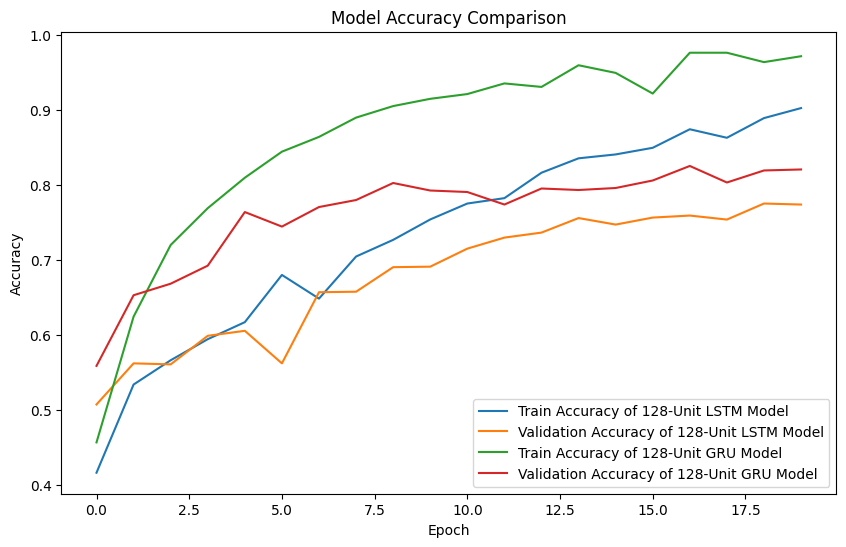

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_LSTM_1a.history['accuracy'], label='Train Accuracy of 128-Unit LSTM Model')
plt.plot(history_LSTM_1a.history['val_accuracy'], label='Validation Accuracy of 128-Unit LSTM Model')
plt.plot(history_GRU_1a.history['accuracy'], label='Train Accuracy of 128-Unit GRU Model')
plt.plot(history_GRU_1a.history['val_accuracy'], label='Validation Accuracy of 128-Unit GRU Model')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

GRU Model performs better than LSTM Model, but also has a stronger tendency to overfit to the training data. The validation accuracy hasn't improved after around the 8th epoch.

#### LSTM with 1D-Conv/BN/MP

In [ ]:
# Model improvement: 2a. Add 1D-Conv/Batch Normalization/Max Pooling before LSTM layers

model_LSTM_2a = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, input_shape=input_shape, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model_LSTM_2a.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_LSTM_2a.summary()
history_LSTM_2a = model_LSTM_2a.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=20)
objects_to_save["history_LSTM_2a"] = history_LSTM_2a

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 130, 32)             │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 130, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 65, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 65, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,074 (250.29 KB)

 Trainable params: 64,010 (250.04 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.3477 - loss: 1.8258 - val_accuracy: 0.5351 - val_loss: 1.3380
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.5424 - loss: 1.2603 - val_accuracy: 0.5598 - val_loss: 1.1840
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.5912 - loss: 1.1374 - val_accuracy: 0.5845 - val_loss: 1.1248
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.6295 - loss: 1.0416 - val_accuracy: 0.6126 - val_loss: 1.1108
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 103ms/step - accuracy: 0.6617 - loss: 0.9556 - val_accuracy: 0.5939 - val_loss: 1.2294
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - accuracy: 0.6851 - loss: 0.8732 - val_accuracy: 0.6520 - val_loss: 1.0052
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.6865 - loss: 0.8917 - val_accuracy: 0.6707 - val_loss: 0.9213
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.7175 - loss: 0.7997

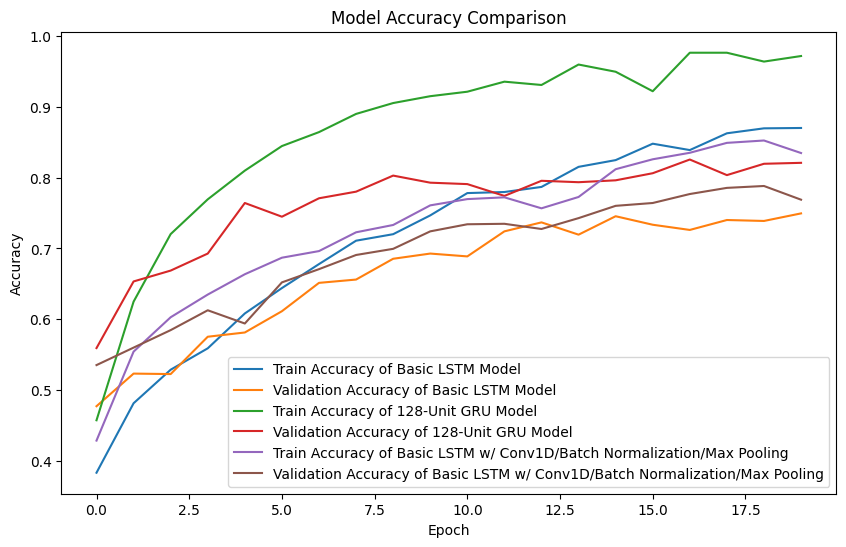

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_LSTM_0.history['accuracy'], label='Train Accuracy of Basic LSTM Model')
plt.plot(history_LSTM_0.history['val_accuracy'], label='Validation Accuracy of Basic LSTM Model')
plt.plot(history_GRU_1a.history['accuracy'], label='Train Accuracy of 128-Unit GRU Model')
plt.plot(history_GRU_1a.history['val_accuracy'], label='Validation Accuracy of 128-Unit GRU Model')
plt.plot(history_LSTM_2a.history['accuracy'], label='Train Accuracy of Basic LSTM with Conv1D/Batch Normalization/Max Pooling')
plt.plot(history_LSTM_2a.history['val_accuracy'], label='Validation Accuracy of Basic LSTM with Conv1D/Batch Normalization/Max Pooling')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Conv1D Model achieved the same accuracy (or even slightly better) as Basic LSTM Model in almost half the computation time. Was able to capture the local features?<br>
--> Keep the Conv1D structure

 128-Unit GRU with 1D-Conv/BN/MP

In [ ]:
# 128GRU+1a. Add 1D-Conv/Batch Normalization/Max Pooling to 128-Unit GRU layers

model_GRU_1a2a = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, input_shape=input_shape, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model_GRU_1a2a.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_GRU_1a2a.summary()
history_GRU_1a2a = model_GRU_1a2a.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=20)
objects_to_save["history_GRU_1a2a"] = history_GRU_1a2a

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 130, 32)             │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 130, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 65, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 65, 128)             │          62,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,594 (670.29 KB)

 Trainable params: 171,530 (670.04 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 193ms/step - accuracy: 0.3389 - loss: 1.7875 - val_accuracy: 0.5177 - val_loss: 1.3116
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 34s 183ms/step - accuracy: 0.5543 - loss: 1.2229 - val_accuracy: 0.5912 - val_loss: 1.1043
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 40s 177ms/step - accuracy: 0.6153 - loss: 1.0320 - val_accuracy: 0.6353 - val_loss: 1.0329
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 34s 181ms/step - accuracy: 0.6734 - loss: 0.8757 - val_accuracy: 0.7021 - val_loss: 0.8284
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step - accuracy: 0.7186 - loss: 0.7495 - val_accuracy: 0.7275 - val_loss: 0.7992
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 43s 194ms/step - accuracy: 0.7771 - loss: 0.6357 - val_accuracy: 0.7014 - val_loss: 0.9036
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 39s 184ms/step - accuracy: 0.8071 - loss: 0.5286 - val_accuracy: 0.7528 - val_loss: 0.7541
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 191ms/step - accuracy: 0.8348 - loss: 0

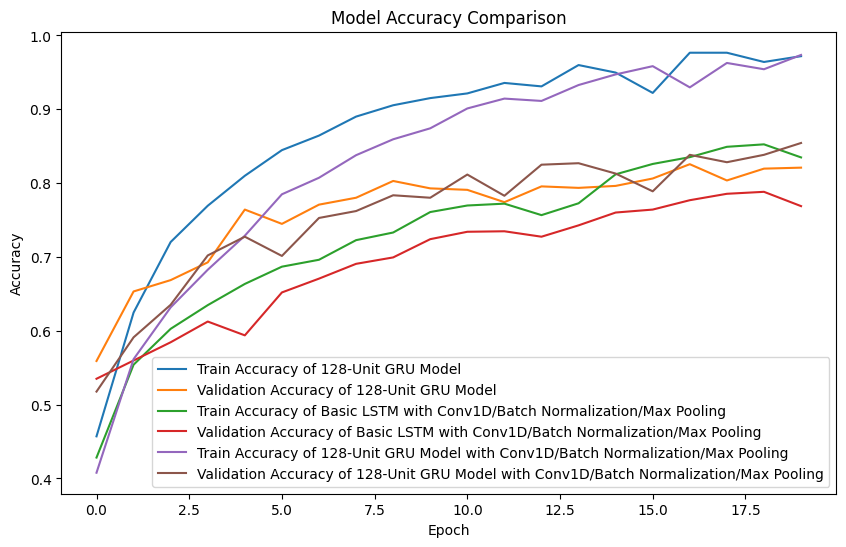

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_GRU_1a.history['accuracy'], label='Train Accuracy of 128-Unit GRU Model')
plt.plot(history_GRU_1a.history['val_accuracy'], label='Validation Accuracy of 128-Unit GRU Model')
plt.plot(history_LSTM_2a.history['accuracy'], label='Train Accuracy of Basic LSTM with Conv1D/Batch Normalization/Max Pooling')
plt.plot(history_LSTM_2a.history['val_accuracy'], label='Validation Accuracy of Basic LSTM with Conv1D/Batch Normalization/Max Pooling')
plt.plot(history_GRU_1a2a.history['accuracy'], label='Train Accuracy of 128-Unit GRU Model with Conv1D/Batch Normalization/Max Pooling')
plt.plot(history_GRU_1a2a.history['val_accuracy'], label='Validation Accuracy of 128-Unit GRU Model with Conv1D/Batch Normalization/Max Pooling')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

128-unit GRU with Conv1 shows about 10% higher validation accuracy in twice the computation time than 64-unit LSTM with Conv1D.
--> Further improvements will be first tested on Basic LSTM with Conv1D

#### LSTM with BN (after LSTM&Dense)

In [ ]:
# 2b. Add Batch Normalization after LSTM & Dense Layers

model_LSTM_2a2b = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, input_shape=input_shape, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.BatchNormalization(),  # BN added
    tf.keras.layers.LSTM(64),
    tf.keras.layers.BatchNormalization(),  # BN added
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.BatchNormalization(),  # BN added
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model_LSTM_2a2b.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history_LSTM_2a2b = model_LSTM_2a2b.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=20)
objects_to_save["history_LSTM_2a2b"] = history_LSTM_2a2b

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.3871 - loss: 1.8462 - val_accuracy: 0.4522 - val_loss: 1.5434
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.5286 - loss: 1.3208 - val_accuracy: 0.5518 - val_loss: 1.2223
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 123ms/step - accuracy: 0.5918 - loss: 1.1559 - val_accuracy: 0.5752 - val_loss: 1.2680
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 35s 91ms/step - accuracy: 0.6117 - loss: 1.0830 - val_accuracy: 0.6420 - val_loss: 1.0416
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.6634 - loss: 0.9332 - val_accuracy: 0.6540 - val_loss: 0.9975
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 0.6803 - loss: 0.9364 - val_accuracy: 0.6139 - val_loss: 1.1634
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.7087 - loss: 0.8395 - val_accuracy: 0.6834 - val_loss: 0.9236
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.7234 - loss: 0.7932 

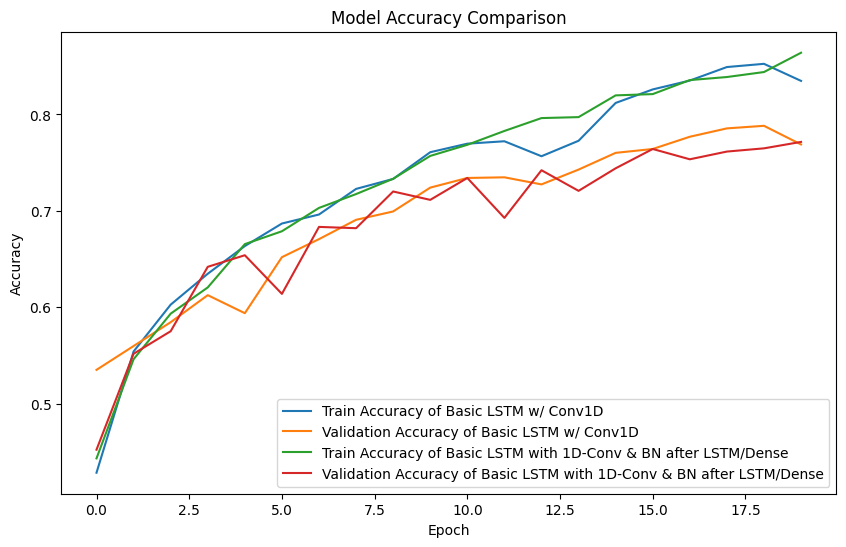

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_LSTM_2a.history['accuracy'], label='Train Accuracy of Basic LSTM with Conv1D')
plt.plot(history_LSTM_2a.history['val_accuracy'], label='Validation Accuracy of Basic LSTM with Conv1D')
plt.plot(history_LSTM_2a2b.history['accuracy'], label='Train Accuracy of Basic LSTM with 1D-Conv & BN after LSTM/Dense')
plt.plot(history_LSTM_2a2b.history['val_accuracy'], label='Validation Accuracy of Basic LSTM with 1D-Conv & BN after LSTM/Dense')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

No significant change by adding BatchNormalization layers after LSTM

In [ ]:
# Model improvement: 3a. Add dropout layers to Basic LSTM with 1D Conv

model_LSTM_2a3a = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, input_shape=input_shape, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model_LSTM_2a3a.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_LSTM_2a3a.summary()
history_LSTM_2a3a = model_LSTM_2a3a.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=20)
objects_to_save["history_LSTM_2a3a"] = history_LSTM_2a3a

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 130, 32)             │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 130, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 65, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 65, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 65, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,074 (250.29 KB)

 Trainable params: 64,010 (250.04 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 102ms/step - accuracy: 0.3158 - loss: 1.8938 - val_accuracy: 0.4342 - val_loss: 1.4679
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 88ms/step - accuracy: 0.5060 - loss: 1.3526 - val_accuracy: 0.5284 - val_loss: 1.2631
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - accuracy: 0.5638 - loss: 1.2357 - val_accuracy: 0.6139 - val_loss: 1.1034
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.6176 - loss: 1.0996 - val_accuracy: 0.6152 - val_loss: 1.0975
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.6393 - loss: 1.0363 - val_accuracy: 0.6486 - val_loss: 0.9962
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.6854 - loss: 0.9400 - val_accuracy: 0.6299 - val_loss: 1.0567
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.6868 - loss: 0.9016 - val_accuracy: 0.6934 - val_loss: 0.9173
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.7050 - loss: 0.8663 -

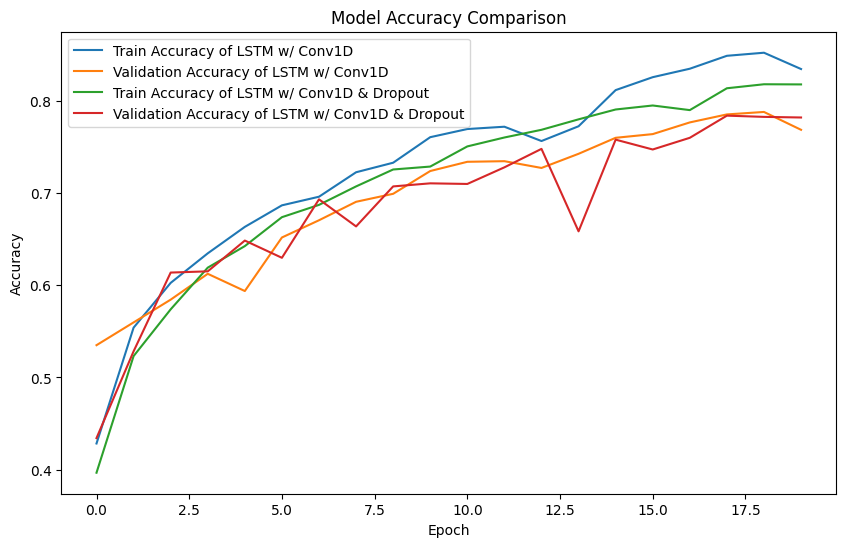

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_LSTM_2a.history['accuracy'], label='Train Accuracy of LSTM with Conv1D')
plt.plot(history_LSTM_2a.history['val_accuracy'], label='Validation Accuracy of LSTM with Conv1D')
plt.plot(history_LSTM_2a3a.history['accuracy'], label='Train Accuracy of LSTM with Conv1D & Dropout')
plt.plot(history_LSTM_2a3a.history['val_accuracy'], label='Validation Accuracy of LSTM with Conv1D & Dropout')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

It looks like that dropout layers mitigated overfitting. The validation accuracy was maintained overall.

#### LSTM with Ridge Regression

In [ ]:
# Model improvement: 3b. Add L2-Norm Penalty (Ridge Regression) to Basic LSTM with 1D Conv
from tensorflow.keras.regularizers import l2  # Import l2 regularizer

model_LSTM_2a3b = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, input_shape=input_shape, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True, kernel_regularizer=l2(0.001)),
    tf.keras.layers.LSTM(64, kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dense(10, activation="softmax")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model_LSTM_2a3b.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_LSTM_2a3b.summary()
history_LSTM_2a3b = model_LSTM_2a3b.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=20, verbose=2)
objects_to_save["history_LSTM_2a3b"] = history_LSTM_2a3b

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)                    │ (None, 130, 32)             │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 130, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 65, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 65, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,074 (250.29 KB)

 Trainable params: 64,010 (250.04 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/20
188/188 - 21s - 114ms/step - accuracy: 0.4289 - loss: 1.7918 - val_accuracy: 0.5284 - val_loss: 1.4959
Epoch 2/20
188/188 - 16s - 86ms/step - accuracy: 0.5546 - loss: 1.4095 - val_accuracy: 0.5691 - val_loss: 1.4143
Epoch 3/20
188/188 - 20s - 108ms/step - accuracy: 0.6092 - loss: 1.2465 - val_accuracy: 0.5718 - val_loss: 1.3481
Epoch 4/20
188/188 - 20s - 108ms/step - accuracy: 0.6468 - loss: 1.1562 - val_accuracy: 0.6232 - val_loss: 1.1854
Epoch 5/20
188/188 - 21s - 109ms/step - accuracy: 0.6553 - loss: 1.1077 - val_accuracy: 0.6553 - val_loss: 1.1163
Epoch 6/20
188/188 - 20s - 107ms/step - accuracy: 0.6934 - loss: 1.0198 - val_accuracy: 0.6754 - val_loss: 1.1122
Epoch 7/20
188/188 - 15s - 81ms/step - accuracy: 0.7079 - loss: 0.9720 - val_accuracy: 0.6693 - val_loss: 1.0832
Epoch 8/20
188/188 - 23s - 122ms/step - accuracy: 0.7273 - loss: 0.9366 - val_accuracy: 0.6907 - val_loss: 1.0225
Epoch 9/20
188/188 - 18s - 94ms/step - accuracy: 0.7445 - loss: 0.8661 - val_accuracy: 0.7

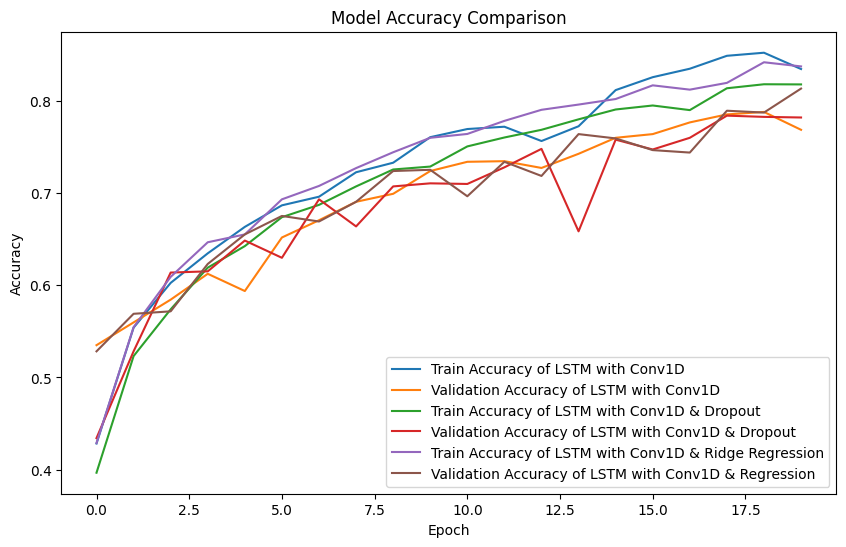

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_LSTM_2a.history['accuracy'], label='Train Accuracy of LSTM with Conv1D')
plt.plot(history_LSTM_2a.history['val_accuracy'], label='Validation Accuracy of LSTM with Conv1D')
plt.plot(history_LSTM_2a3a.history['accuracy'], label='Train Accuracy of LSTM with Conv1D & Dropout')
plt.plot(history_LSTM_2a3a.history['val_accuracy'], label='Validation Accuracy of LSTM with Conv1D & Dropout')
plt.plot(history_LSTM_2a3b.history['accuracy'], label='Train Accuracy of LSTM with Conv1D & Ridge Regression')
plt.plot(history_LSTM_2a3b.history['val_accuracy'], label='Validation Accuracy of LSTM with Conv1D & Regression')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### LSTM using augmented data

In [ ]:
# 4. Data Augmentation

import soundfile as sf

def pitch_speed_data_augmentation(y, sr, pitch_factor, speed_factor):
    y_pitch_speed = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=pitch_factor)
    y_pitch_speed = librosa.effects.time_stretch(y_pitch_speed, rate=speed_factor) # Change here: use rate=speed_factor
    return y_pitch_speed

def add_noise_data_augmentation(y, noise_factor=0.005):
    noise = np.random.randn(len(y))
    augmented_data = y + noise_factor * noise
    augmented_data = augmented_data.astype('float32')
    return augmented_data


# Change pitch & speed for 1/4 & add noise for another 1/4 of each genre
def process_and_save(file_path, save_dir, augmentation_type, sr=None):
    y, sr = librosa.load(file_path, sr=sr)
    if augmentation_type == 'pitch_speed':
        y_augmented = pitch_speed_data_augmentation(y, sr, pitch_factor=1.0, speed_factor=0.9)
    elif augmentation_type == 'noise':
        y_augmented = add_noise_data_augmentation(y, noise_factor=0.01)
    else:
        raise ValueError("Invalid augmentation type specified")

    save_path = os.path.join(save_dir, os.path.basename(file_path))
    sf.write(save_path, y_augmented, sr, format='WAV')

for genre in os.listdir(data_path):
    genre_path = os.path.join(data_path, genre)

    # Get all files within the genre directory, including subdirectories
    all_files = []
    for root, _, files_in_root in os.walk(genre_path):
        for file in files_in_root:
            if file.endswith('.wav'):  # Only consider .wav files
                all_files.append(os.path.join(root, file))

    np.random.shuffle(all_files)  # shuffle files list
    files = all_files[:len(all_files) // 2]  # select half the files
    half_point = len(files) // 2

    save_dir_pitch_speed = os.path.join(genre_path, 'augmented_pitch_speed')
    save_dir_noise = os.path.join(genre_path, 'augmented_noise')

    if not os.path.exists(save_dir_pitch_speed):
        os.makedirs(save_dir_pitch_speed)
    if not os.path.exists(save_dir_noise):
        os.makedirs(save_dir_noise)

    # Change pitch & speed
    for file_path in files[:half_point]:  # Use file_path directly
        process_and_save(file_path, save_dir_pitch_speed, 'pitch_speed')

    # Add noise
    for file_path in files[half_point:]:  # Use file_path directly
        process_and_save(file_path, save_dir_noise, 'noise')

print("Data augmentation completed.")

Data augmentation completed.


In [ ]:
# Modify get_mfcc function to obtain MFCC of the augmented files

def get_mfcc_augmented(data_path, n_mfcc=13, n_fft=2048, hop_length=512):
    data_augmented = {"labels": [], "mfcc": []}
    sample_rate = 22050

    # Specify the subfolder where the augmented files exist
    augmented_folders = ['augmented_pitch_speed', 'augmented_noise']

    for genre_dir in os.listdir(data_path):
        genre_path = os.path.join(data_path, genre_dir)
        for subfolder in augmented_folders:
            subfolder_path = os.path.join(genre_path, subfolder)
            if not os.path.exists(subfolder_path):
                continue

            for f in os.listdir(subfolder_path):
                if not f.endswith('.wav'):
                    continue

                file_path = os.path.join(subfolder_path, f)
                try:
                    y, sr = librosa.load(file_path, sr=sample_rate)
                    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    if len(mfcc) > 0:
                        data_augmented["labels"].append(genre_dir)
                        data_augmented["mfcc"].append(mfcc.tolist())
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")

    return data_augmented

def combine_data(original, augmented):
    combined = {"labels": [], "mfcc": []}
    combined["labels"] = original["labels"] + augmented["labels"]
    combined["mfcc"] = original["mfcc"] + augmented["mfcc"]
    return combined


data_augmented = get_mfcc_augmented(data_path, n_mfcc=13, n_fft=2048, hop_length=512)
combined_data = combine_data(data, data_augmented)

objects_to_save["data_augmented"] = data_augmented
objects_to_save["combined_data"] = combined_data

In [ ]:
# dataとdata_augmentedの配列の長さが違うので、そのままではnp.arrayを使えない
# →combined_data を一定の長さにトリミング

# Find the most common length
lengths = [len(mfcc) for mfcc in combined_data["mfcc"]]
most_common_length = np.bincount(lengths).argmax()

# Trim all MFCC to most_common_length
trimmed_mfcc = [mfcc[:most_common_length] for mfcc in combined_data["mfcc"] if len(mfcc) >= most_common_length]

# Trim labels to most_common_length if the corresponding MFCC was trimmed
trimmed_labels = [label for mfcc, label in zip(combined_data["mfcc"], combined_data["labels"]) if len(mfcc) >= most_common_length]

x = np.array(trimmed_mfcc)
y = np.array(trimmed_labels)

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.25)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

input_shape = (x_train.shape[1], x_train.shape[2])

In [ ]:
model_LSTM_2a4ab = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model_LSTM_2a4ab.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model_LSTM_2a4ab.summary()

history_LSTM_2a4ab = model_LSTM_2a4ab.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=20)
objects_to_save["history_LSTM_2a4ab"] = history_LSTM_2a4ab

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 130, 32)             │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 130, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 65, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 65, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,074 (250.29 KB)

 Trainable params: 64,010 (250.04 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - accuracy: 0.3414 - loss: 1.8445 - val_accuracy: 0.5235 - val_loss: 1.3387
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - accuracy: 0.5304 - loss: 1.3081 - val_accuracy: 0.5878 - val_loss: 1.1933
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - accuracy: 0.5937 - loss: 1.1509 - val_accuracy: 0.5967 - val_loss: 1.1149
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - accuracy: 0.6286 - loss: 1.0806 - val_accuracy: 0.6622 - val_loss: 1.0110
Epoch 5/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.6559 - loss: 0.9957 - val_accuracy: 0.6393 - val_loss: 1.0184
Epoch 6/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.6869 - loss: 0.9055 - val_accuracy: 0.6845 - val_loss: 0.9233
Epoch 7/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.7060 - loss: 0.8582 - val_accuracy: 0.6870 - val_loss: 0.9248
Epoch 8/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - accuracy: 0.7312 - loss: 0.7577 -

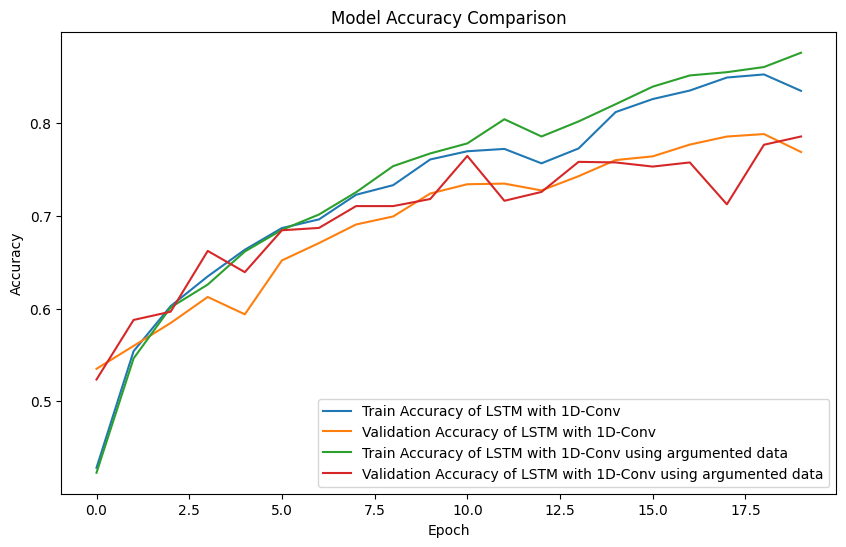

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_LSTM_2a.history['accuracy'], label='Train Accuracy of LSTM with 1D-Conv')
plt.plot(history_LSTM_2a.history['val_accuracy'], label='Validation Accuracy of LSTM with 1D-Conv')
plt.plot(history_LSTM_2a4ab.history['accuracy'], label='Train Accuracy of LSTM with 1D-Conv using argumented data')
plt.plot(history_LSTM_2a4ab.history['val_accuracy'], label='Validation Accuracy of LSTM with 1D-Conv using argumented data')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Using the augmented dataset didn't improve the model much.


## CNNモデル

In [ ]:
# Conv2D

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(data["labels"])
x = np.array(data["mfcc"])
y = np.array(data["labels"])
x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.25)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

# Reshape the input data to add a channel dimension so it fits the CNN model
x_train = x_train[..., np.newaxis]
x_val = x_val[..., np.newaxis]
x_test = x_test[..., np.newaxis]

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])  # (height, width, channels)

# Basic model using Conv2D
model_CNN_0 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'), # padding='same' -> the output size remains the same as the input size, preventing negative dimensions
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same'), # Reduced kernel size to ensure the output size remains positive
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model_CNN_0.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_CNN_0.summary()
history_CNN_0 = model_CNN_0.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=20)
objects_to_save["history_CNN_0"] = history_CNN_0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 130, 13, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 65, 6, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 65, 6, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 3, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 3, 128)          │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12288)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │       1,572,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,994 (6.20 MB)

 Trainable params: 1,625,994 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 30s 145ms/step - accuracy: 0.3217 - loss: 4.8282 - val_accuracy: 0.4830 - val_loss: 1.4113
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - accuracy: 0.5747 - loss: 1.1872 - val_accuracy: 0.5772 - val_loss: 1.1612
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 39s 118ms/step - accuracy: 0.6769 - loss: 0.9126 - val_accuracy: 0.5752 - val_loss: 1.2091
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 40s 116ms/step - accuracy: 0.7696 - loss: 0.6647 - val_accuracy: 0.6192 - val_loss: 1.1078
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 26s 136ms/step - accuracy: 0.8313 - loss: 0.4875 - val_accuracy: 0.6065 - val_loss: 1.2661
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 40s 129ms/step - accuracy: 0.8784 - loss: 0.3814 - val_accuracy: 0.6386 - val_loss: 1.2162
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 40s 122ms/step - accuracy: 0.9321 - loss: 0.2066 - val_accuracy: 0.6673 - val_loss: 1.2170
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - accuracy: 0.9569 - loss: 0

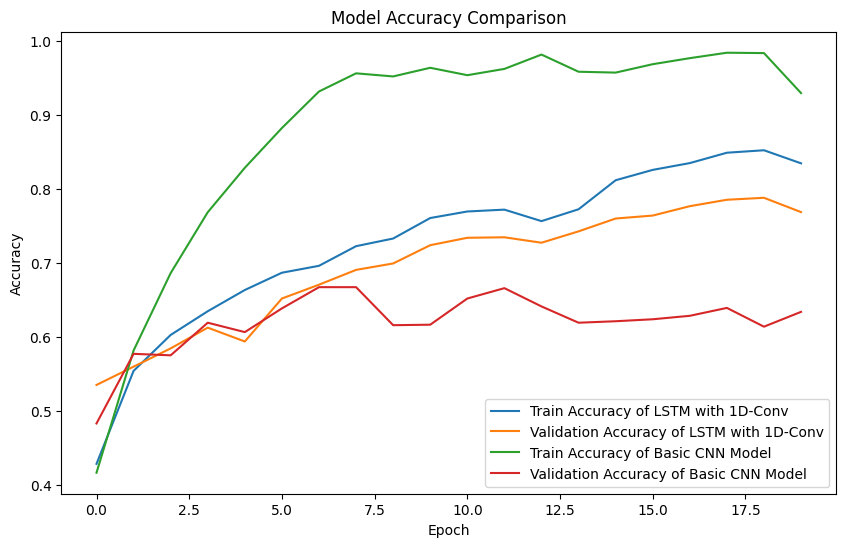

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_LSTM_0.history['accuracy'], label='Train Accuracy of Basic LSTM Model')
plt.plot(history_LSTM_0.history['val_accuracy'], label='Validation of Basic LSTM Model')
plt.plot(history_LSTM_2a.history['accuracy'], label='Train Accuracy of LSTM with 1D-Conv')
plt.plot(history_LSTM_2a.history['val_accuracy'], label='Validation Accuracy of LSTM with 1D-Conv')
plt.plot(history_CNN_0.history['accuracy'], label='Train Accuracy of Basic CNN Model')
plt.plot(history_CNN_0.history['val_accuracy'], label='Validation Accuracy of Basic CNN Model')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

The basic Conv2D model overfits the training data way too much
--> No further experiments on the Conv2D approach.


## 1次元CNNモデル

In [ ]:
# Basic Conv1D Model

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(data["labels"])
x = np.array(data["mfcc"])
y = np.array(data["labels"])
x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.25)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
input_shape = (x_train.shape[1], x_train.shape[2])

# Stack Conv1D layers aiming to extract more complex local features
model_Conv1D_0 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(64, 3, activation='relu', input_shape=input_shape),
    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(3),
    tf.keras.layers.Conv1D(128, 3, activation='relu'),
    tf.keras.layers.Conv1D(128, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),  # reduce dimensions
    tf.keras.layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model_Conv1D_0.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_Conv1D_0.summary()
history_Conv1D_0 = model_Conv1D_0.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=20)
objects_to_save["history_Conv1D_0"] = history_Conv1D_0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)                    │ (None, 128, 64)             │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 126, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 42, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 40, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 38, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 90,186 (352.29 KB)

 Trainable params: 90,186 (352.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.3622 - loss: 2.9490 - val_accuracy: 0.5498 - val_loss: 1.3056
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.5725 - loss: 1.1699 - val_accuracy: 0.6406 - val_loss: 1.0238
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.6536 - loss: 0.9630 - val_accuracy: 0.7221 - val_loss: 0.8328
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.7176 - loss: 0.8209 - val_accuracy: 0.7268 - val_loss: 0.7778
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.7491 - loss: 0.7237 - val_accuracy: 0.7395 - val_loss: 0.7708
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.7783 - loss: 0.6386 - val_accuracy: 0.7582 - val_loss: 0.7096
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.7826 - loss: 0.6062 - val_accuracy: 0.7582 - val_loss: 0.7181
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8165 - loss: 0.5180 - val_ac

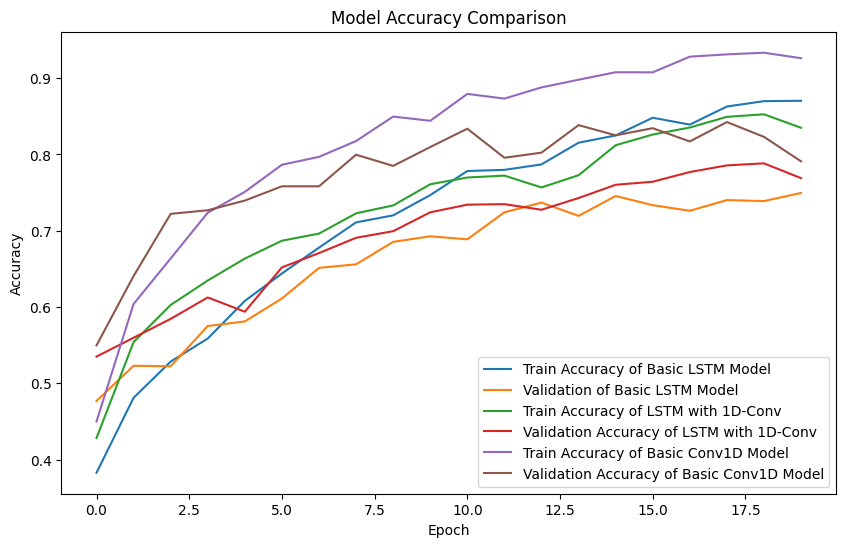

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_LSTM_0.history['accuracy'], label='Train Accuracy of Basic LSTM Model')
plt.plot(history_LSTM_0.history['val_accuracy'], label='Validation of Basic LSTM Model')
plt.plot(history_LSTM_2a.history['accuracy'], label='Train Accuracy of LSTM with 1D-Conv')
plt.plot(history_LSTM_2a.history['val_accuracy'], label='Validation Accuracy of LSTM with 1D-Conv')
plt.plot(history_Conv1D_0.history['accuracy'], label='Train Accuracy of Basic Conv1D Model')
plt.plot(history_Conv1D_0.history['val_accuracy'], label='Validation Accuracy of Basic Conv1D Model')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

The 1D CNN model achieves higher accuracy than the LSTM model + faster :))

### 1次元CNNモデルの改善案
##### 1. フィルタサイズ変更
  1. a) 連続するConv1D layersの二つ目のカーネルサイズを3->5　→より多様なパターンを学習できる？

##### 2. 層の追加
  1. a) バッチ正規化
  2. b) ドロップアウト

##### 3. 他モデルの併用
  1. a) LSTM
  2. b) GRU


#### Conv1D with different filter sizes

In [ ]:
# Change the filter size from 3 -> 5

model_Conv1D_1a = tf.keras.Sequential([
    tf.keras.layers.Conv1D(64, 3, activation='relu', input_shape=input_shape),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),  # 3->5
    tf.keras.layers.MaxPooling1D(3),
    tf.keras.layers.Conv1D(128, 3, activation='relu'),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),  # 3->5
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model_Conv1D_1a.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_Conv1D_1a.summary()
history_Conv1D_1a = model_Conv1D_1a.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=20)
objects_to_save["history_Conv1D_1a"] = history_Conv1D_1a

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)                   │ (None, 128, 64)             │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ (None, 124, 64)             │          20,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 41, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 39, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 35, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 131,146 (512.29 KB)

 Trainable params: 131,146 (512.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.3549 - loss: 2.9430 - val_accuracy: 0.5484 - val_loss: 1.2241
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.5703 - loss: 1.2069 - val_accuracy: 0.5992 - val_loss: 1.1486
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.6203 - loss: 1.0377 - val_accuracy: 0.6880 - val_loss: 0.9474
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.6750 - loss: 0.8978 - val_accuracy: 0.7321 - val_loss: 0.7879
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7376 - loss: 0.7594 - val_accuracy: 0.6780 - val_loss: 0.9834
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.7504 - loss: 0.7269 - val_accuracy: 0.7234 - val_loss: 0.8060
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.7736 - loss: 0.6690 - val_accuracy: 0.7709 - val_loss: 0.6841
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.8242 - loss: 0.4983 - val

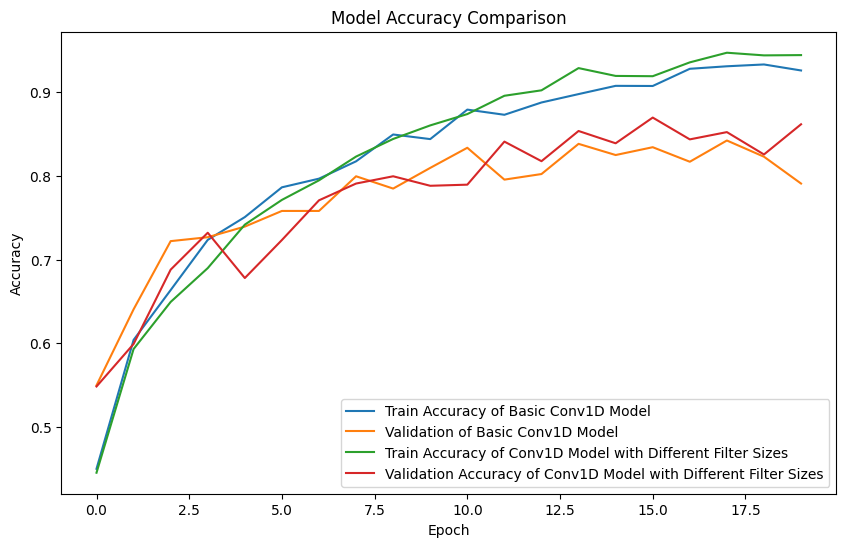

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_Conv1D_0.history['accuracy'], label='Train Accuracy of Basic Conv1D Model')
plt.plot(history_Conv1D_0.history['val_accuracy'], label='Validation of Basic Conv1D Model')
plt.plot(history_Conv1D_1a.history['accuracy'], label='Train Accuracy of Conv1D Model with Different Filter Sizes')
plt.plot(history_Conv1D_1a.history['val_accuracy'], label='Validation Accuracy of Conv1D Model with Different Filter Sizes')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

A slight, but not a significant improvement in validation accuracy by introducing different filter sizes

#### Conv1D with BN

In [ ]:
# Add Batch Normalization layers

model_Conv1D_2a = tf.keras.Sequential([
    tf.keras.layers.Conv1D(64, 3, activation='relu', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),  # Add BN layer

    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),  # Add BN layer

    tf.keras.layers.MaxPooling1D(3),

    tf.keras.layers.Conv1D(128, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),  # Add BN layer

    tf.keras.layers.Conv1D(128, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),  # Add BN layer

    tf.keras.layers.GlobalAveragePooling1D(),

    tf.keras.layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model_Conv1D_2a.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_Conv1D_2a.summary()
history_Conv1D_2a = model_Conv1D_2a.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=20)
objects_to_save["history_Conv1D_2a"] = history_Conv1D_2a

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)                   │ (None, 128, 64)             │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 128, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ (None, 126, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 126, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 42, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 40, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 40, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_18 (Conv1D)                   │ (None, 38, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 38, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,722 (358.29 KB)

 Trainable params: 90,954 (355.29 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - accuracy: 0.5049 - loss: 1.3929 - val_accuracy: 0.6199 - val_loss: 1.1541
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.6861 - loss: 0.8962 - val_accuracy: 0.6740 - val_loss: 0.8929
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.7454 - loss: 0.7546 - val_accuracy: 0.7301 - val_loss: 0.7779
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.7738 - loss: 0.6564 - val_accuracy: 0.7495 - val_loss: 0.7253
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.8204 - loss: 0.5316 - val_accuracy: 0.7856 - val_loss: 0.6424
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.8372 - loss: 0.4932 - val_accuracy: 0.8029 - val_loss: 0.5778
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.8450 - loss: 0.4553 - val_accuracy: 0.8130 - val_loss: 0.5451
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.8713 - loss: 0.3812 - val

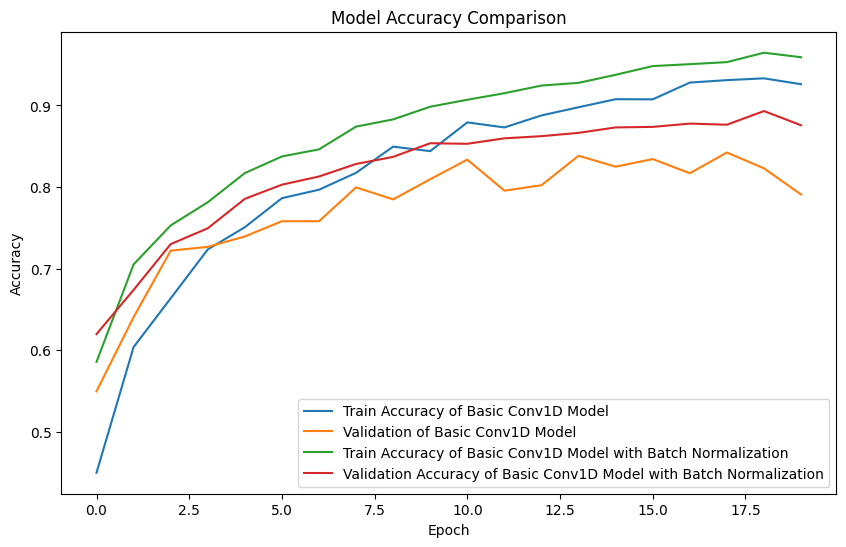

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_Conv1D_0.history['accuracy'], label='Train Accuracy of Basic Conv1D Model')
plt.plot(history_Conv1D_0.history['val_accuracy'], label='Validation of Basic Conv1D Model')
plt.plot(history_Conv1D_2a.history['accuracy'], label='Train Accuracy of Basic Conv1D Model with Batch Normalization')
plt.plot(history_Conv1D_2a.history['val_accuracy'], label='Validation Accuracy of Basic Conv1D Model with Batch Normalization')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Adding BN layers improved the model :)

#### Conv1D with BN/Dropout

In [ ]:
# Add Batch Normalization & Dropout layers

model_Conv1D_2ab = tf.keras.Sequential([
    tf.keras.layers.Conv1D(64, 3, activation='relu', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),  # Add BN layer
    tf.keras.layers.Dropout(0.2),  # Add Dropout layer

    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),  # Add BN layer
    tf.keras.layers.Dropout(0.2),  # Add Dropout layer

    tf.keras.layers.MaxPooling1D(3),

    tf.keras.layers.Conv1D(128, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),  # Add BN layer
    tf.keras.layers.Dropout(0.2),  # Add Dropout layer

    tf.keras.layers.Conv1D(128, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),  # Add BN layer
    tf.keras.layers.Dropout(0.2),  # Add Dropout layer

    tf.keras.layers.GlobalAveragePooling1D(),

    tf.keras.layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model_Conv1D_2ab.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_Conv1D_2ab.summary()
history_Conv1D_2ab = model_Conv1D_2ab.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=20)
objects_to_save["history_Conv1D_2ab"] = history_Conv1D_2ab

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_19 (Conv1D)                   │ (None, 128, 64)             │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 128, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_20 (Conv1D)                   │ (None, 126, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 126, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 126, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 42, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_21 (Conv1D)                   │ (None, 40, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 40, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 40, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_22 (Conv1D)                   │ (None, 38, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 38, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 38, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,722 (358.29 KB)

 Trainable params: 90,954 (355.29 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.4671 - loss: 1.4907 - val_accuracy: 0.5625 - val_loss: 1.1737
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 64ms/step - accuracy: 0.6537 - loss: 1.0012 - val_accuracy: 0.6687 - val_loss: 1.0239
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.7202 - loss: 0.8141 - val_accuracy: 0.6560 - val_loss: 1.0493
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 64ms/step - accuracy: 0.7537 - loss: 0.7116 - val_accuracy: 0.6867 - val_loss: 1.0881
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.7734 - loss: 0.6508 - val_accuracy: 0.7014 - val_loss: 1.0049
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.7962 - loss: 0.5899 - val_accuracy: 0.7255 - val_loss: 0.8980
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.8177 - loss: 0.5331 - val_accuracy: 0.7054 - val_loss: 0.9199
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.8238 - loss: 0.5040 - 

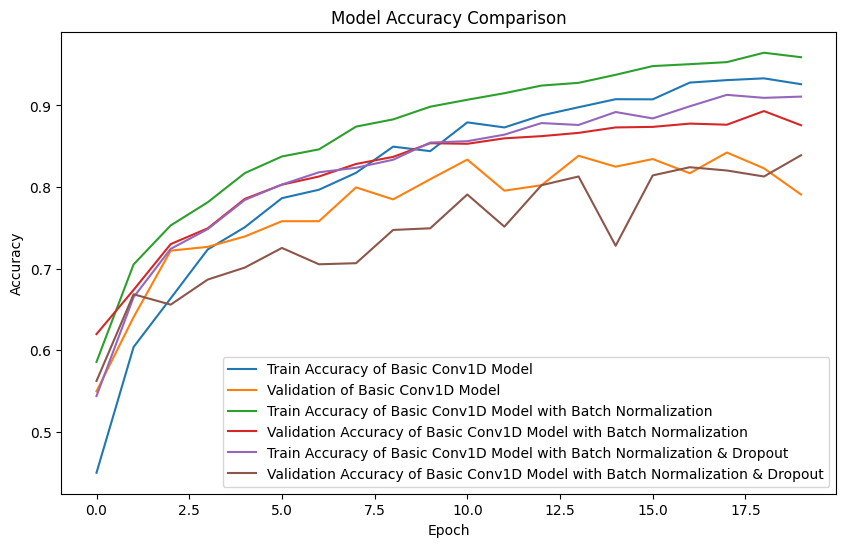

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_Conv1D_0.history['accuracy'], label='Train Accuracy of Basic Conv1D Model')
plt.plot(history_Conv1D_0.history['val_accuracy'], label='Validation of Basic Conv1D Model')
plt.plot(history_Conv1D_2a.history['accuracy'], label='Train Accuracy of Basic Conv1D Model with Batch Normalization')
plt.plot(history_Conv1D_2a.history['val_accuracy'], label='Validation Accuracy of Basic Conv1D Model with Batch Normalization')
plt.plot(history_Conv1D_2ab.history['accuracy'], label='Train Accuracy of Basic Conv1D Model with Batch Normalization & Dropout')
plt.plot(history_Conv1D_2ab.history['val_accuracy'], label='Validation Accuracy of Basic Conv1D Model with Batch Normalization & Dropout')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Dropout layers didn't contribute to the suppression of overfitting, and reduced accuracy.
--> Only leave the BatchNormalization layers

#### Conv1D with BN & LSTM layers

In [ ]:
# Combine with LSTM Model - add a LSTM layer after Conv1D layers
# ... aiming to analyze local features extracted by Conv1D along the time axis
# (also prevents LSTM from process uncompressed data )

model_Conv1D_2a3a = tf.keras.Sequential([
    tf.keras.layers.Conv1D(64, 3, activation='relu', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(3),

    tf.keras.layers.Conv1D(128, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(128, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    # LSTM layer
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.GlobalAveragePooling1D(),

    tf.keras.layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model_Conv1D_2a3a.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_Conv1D_2a3a.summary()
history_Conv1D_2a3a = model_Conv1D_2a3a.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=20)
objects_to_save["history_Conv1D_2a3a"] = history_Conv1D_2a3a

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_27 (Conv1D)                   │ (None, 128, 64)             │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 128, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_28 (Conv1D)                   │ (None, 126, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 126, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 42, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_29 (Conv1D)                   │ (None, 40, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 40, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_30 (Conv1D)                   │ (None, 38, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 38, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 38, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_5           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 223,306 (872.29 KB)

 Trainable params: 222,538 (869.29 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 31s 121ms/step - accuracy: 0.4733 - loss: 1.4920 - val_accuracy: 0.6059 - val_loss: 1.1191
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 33s 174ms/step - accuracy: 0.6598 - loss: 0.9689 - val_accuracy: 0.7054 - val_loss: 0.8637
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 32s 127ms/step - accuracy: 0.7262 - loss: 0.8044 - val_accuracy: 0.7248 - val_loss: 0.8085
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 39s 119ms/step - accuracy: 0.7487 - loss: 0.7110 - val_accuracy: 0.7695 - val_loss: 0.6962
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - accuracy: 0.7732 - loss: 0.6239 - val_accuracy: 0.7809 - val_loss: 0.6113
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - accuracy: 0.8094 - loss: 0.5545 - val_accuracy: 0.7695 - val_loss: 0.6434
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 130ms/step - accuracy: 0.8436 - loss: 0.4517 - val_accuracy: 0.8016 - val_loss: 0.5662
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 48s 165ms/step - accuracy: 0.8603 - loss: 0

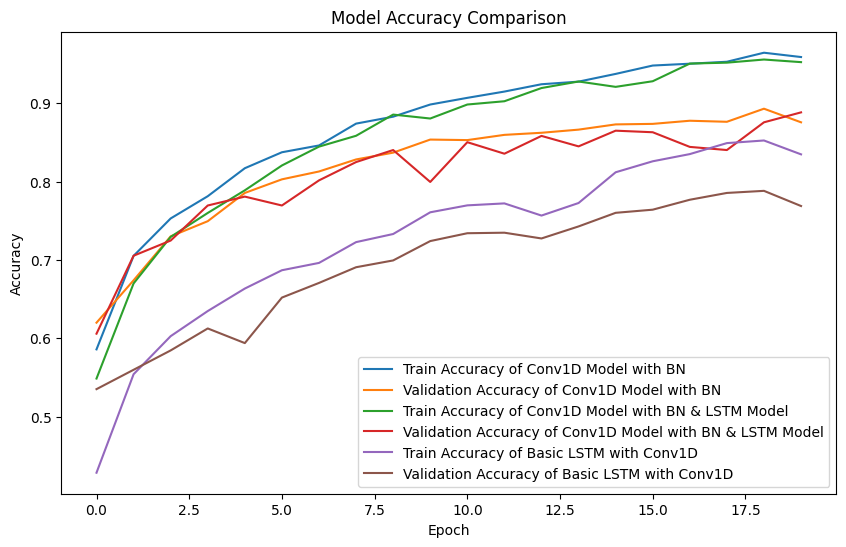

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_Conv1D_2a.history['accuracy'], label='Train Accuracy of Conv1D Model with BN')
plt.plot(history_Conv1D_2a.history['val_accuracy'], label='Validation Accuracy of Conv1D Model with BN')
plt.plot(history_Conv1D_2a3a.history['accuracy'], label='Train Accuracy of Conv1D Model with BN & LSTM')
plt.plot(history_Conv1D_2a3a.history['val_accuracy'], label='Validation Accuracy of Conv1D Model with BN & LSTM')
plt.plot(history_LSTM_2a.history['accuracy'], label='Train Accuracy of LSTM Model with Conv1D')
plt.plot(history_LSTM_2a.history['val_accuracy'], label='Validation Accuracy of LSTM Model with Conv1D')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Combining with LSTM Model reduced the accuracy.<br>
The same can be expected when combining with GRU Model --> Won't do.

## オブジェクトとモデルの保存



In [ ]:
# Save objects_to_save into pickle
with open(os.path.join(base_path, 'saved_state.pkl'), 'wb') as f:
    pickle.dump(objects_to_save, f)

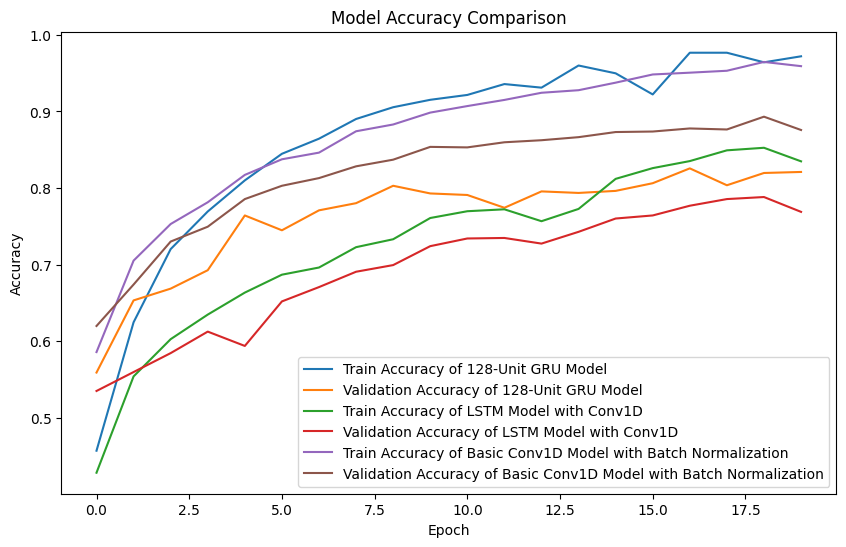

In [ ]:
# Final comparison - 128-Unit GRU Model / 64-Unit LSTM Model with Conv1D / Conv1D Model with Batch Normalization
plt.figure(figsize=(10, 6))
plt.plot(history_GRU_1a.history['accuracy'], label='Train Accuracy of 128-Unit GRU Model')
plt.plot(history_GRU_1a.history['val_accuracy'], label='Validation Accuracy of 128-Unit GRU Model')
plt.plot(history_LSTM_2a.history['accuracy'], label='Train Accuracy of LSTM Model with Conv1D')
plt.plot(history_LSTM_2a.history['val_accuracy'], label='Validation Accuracy of LSTM Model with Conv1D')
plt.plot(history_Conv1D_2a.history['accuracy'], label='Train Accuracy of Basic Conv1D Model with Batch Normalization')
plt.plot(history_Conv1D_2a.history['val_accuracy'], label='Validation Accuracy of Basic Conv1D Model with Batch Normalization')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# Save model_GRU_1a & model_Conv1D_2a
model_GRU_1a.save(os.path.join(base_path, 'GTZAN_128GRU.keras'))
model_Conv1D_2a.save(os.path.join(base_path, 'GTZAN_Conv1D_BN.keras'))

## モデルの検証
classification_test.ipynbにてサンプルを用いて検証。

## 結論

モデル構築の際の検証では、1次元畳み込みを用いたモデルが精度・計算効率両方の点において優れた結果を出した。また1次元畳み込み層の後にLSTM層を追加した場合にも成果が優れなかったことからも、今回のモデル構築においては曲の時空間的情報よりも局所的な特徴情報が分類精度の向上に役立ったと言えるかもしれない。
またConv2Dを用いた畳み込みモデルは楽曲データの周波数を画像として捉えその特徴を抽出する狙いで検証されたが、少なくとも最小限の層構造においては有効的なアプローチとは言えなかった。


GTZANデータセットで最も良い検証精度（共に検証データで85%程度の正解率）を出した128ユニットのGRUモデル（GRUモデル）と1次元畳み込みにバッチ正規化を加えた二つのモデル（Conv1Dモデル）を用いて実際の楽曲サンプルの分類を行なったところ、かなり異なる分類結果となり、異なる特徴を抽出していることが浮き彫りになった。どちらのモデルも実際の楽曲サンプルの分類では、（実際のジャンルのラベル付がある程度恣意的であったとはいえ）モデル検証時よりもかなり精度が下がった。全体的に、誤分類の内容も含めて、GRUモデルの方Conv1Dモデルより正確な分類を行ったように思われた。

## 今後のモデル改善案

1. 交差検証＆異なるデータセットの利用<br>

  データセット例
* [ISMIR 2004](https://ismir2004.ismir.net/genre_contest/) - [Prabhakar & Lee (2023)](http://dx.doi.org/10.54097/hset.v39i.6494)
* [MagnaTagATune](https://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset) - [Prabhakar & Lee (2023)](http://dx.doi.org/10.54097/hset.v39i.6494)
* [FMA: A Dataset For Music Analysis](https://github.com/mdeff/fma) - [Luo (2023)](http://dx.doi.org/10.54097/hset.v39i.6494)

<br>

2. 特徴量の工夫

* [Yi et al. (2021)](https://doi.org/10.1109/ICCCS52626.2021.9449177) の研究では、MFCCと**Zero crossing rate (ZCR)**が組み合わせて用いられている
* [Ashraf et al. (2023)](https://doi.org/10.3390/app13031476) の研究では、MFCCと**Mel-spectrum**が組み合わせて用いられている
* [Li (2024)](https://doi.org/10.1016/j.heliyon.2024.e24892) の研究では、MFCCと**Short-Time [Fourier Transform](https://www.sciencedirect.com/topics/biochemistry-genetics-and-molecular-biology/fourier-transform) (STFT)**が組み合わせて用いられている

<br>

3. モデル改善
* [Ashraf et al. (2023)](https://doi.org/10.3390/app13031476): Mel-spectrogram利用時にはCNN & Bi-GRUの組み合わせが高い精度を出した
* [Li (2024)](https://doi.org/10.1016/j.heliyon.2024.e24892) はBHOアルゴリズムでハイパーパラメータを調整している


